# Inferential statistics II - Bootstrapping

## Introduction

In the previous exercises you performed frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold in your case, and what you want to do has a known theoretical distribution, for example the mean of a sampling distribution that we looked at.

In these exercises we are once again going to load in the medical charge data but this time we are going to make inferences about the population using bootstrapping, that is simulating repeated re-runs of an experiment. If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

Whilst these exercises do not strictly depend on these concepts, before working through them, you should have completed the preceding assignment and have a good understanding of such frequentist concepts as
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete these exercises, you should have covered the material on how to calculate bootstrap replicates of summary statistics. Having an appreciation of what confidence intervals and p-values are will be helpful.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you would like to verify your calculations and check you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

Here is the question again:  The administrator is concerned that the actual average charge has fallen below 12000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?  Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A one-sided or two-sided interval? Calculate the critical value and the relevant 95% confidence interval for the mean and comment on whether the administrator should be concerned?

In [4]:
np.random.seed(47)
N_rep = 10000
sample_charges = med_charges['charges']

In [5]:
# define a function that will return a bootstrap replicate for 1d data
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [6]:
# define a function that will iterate over the bootstrap replicate function to return multiple replicates
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [7]:
bs_reps_charges = draw_bs_reps(sample_charges,np.mean,N_rep)

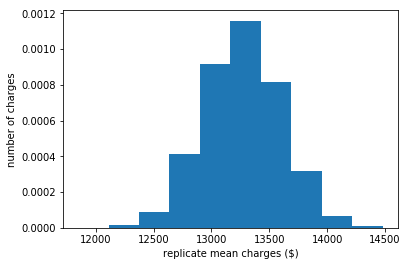

In [8]:
_ = plt.hist(bs_reps_charges, density=True)
_ = plt.xlabel('replicate mean charges ($)')
_ = plt.ylabel('number of charges')
plt.show()

In [9]:
confidence_interval = np.percentile(bs_reps_charges, 5)
print('95% confident the mean will be above', confidence_interval)

95% confident the mean will be above 12724.467921704


If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember in the previous exercise set, we saw there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__  In this case, the null hypothesis will say that the standard deviation of the insurance and the non-insurance claim charges will be the same.  We can make our two samples with Permutation to satisfy the null hypothesis.  Then, we will take the difference between the standard deviations of the two groups.  Then we will look at the possibility that the actual standard deviation happened in accordance with the null hypothesis, giving the p-value.  

In [10]:
charges_w_ins = med_charges[med_charges['insuranceclaim']==1]['charges']
charges_wo_ins = med_charges[med_charges['insuranceclaim']==0]['charges']

In [11]:
emp_diff = np.std(charges_w_ins) - np.std(charges_wo_ins)
print('Difference of the standard deviations from the sample: ',emp_diff)

Difference of the standard deviations from the sample:  7596.256408655178


In [12]:
bs_replicates = np.empty(10000)
for i in range(10000):
    bs_replicates[i] = np.std(np.random.choice(charges_w_ins, len(charges_w_ins))) - np.std(np.random.choice(charges_wo_ins, len(charges_wo_ins)))

In [13]:
confidence_interval = np.percentile(bs_replicates, [2.5,97.5])
print('95% confident the difference in standard deviation will be between', confidence_interval[0], 'and', confidence_interval[1])

95% confident the difference in standard deviation will be between 6676.061773368811 and 8486.946483720005


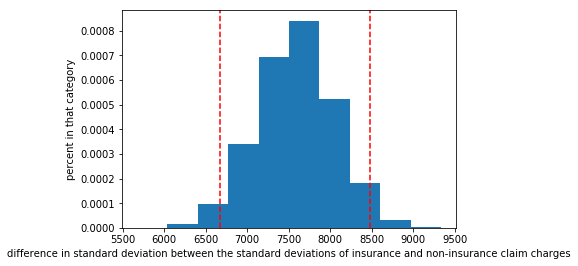

In [14]:
_ = plt.hist(bs_replicates, density=True)
_ = plt.xlabel('difference in standard deviation between the standard deviations of insurance and non-insurance claim charges')
_ = plt.ylabel('percent in that category')
_ = plt.axvline(confidence_interval[0], color='r', linestyle='--')
_ = plt.axvline(confidence_interval[1], color='r', linestyle='--')
plt.show()

In [15]:
# define a formula to create permutation samples from two datasets
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [16]:
#Generate the permutation sample so it will match the null hypothesis
perm_1, perm_2 = permutation_sample(charges_w_ins, charges_wo_ins)

# Compute 10,000 bootstrap replicates from the permutated arrays
bs_replicates_a = draw_bs_reps(perm_1, np.std, 10000)
bs_replicates_b = draw_bs_reps(perm_2, np.std, 10000)

# Get replicates of difference of standard deviations
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print the p-value:  p
p = np.sum(emp_diff <= bs_replicates)/10000
print('p-value =', p)

p-value = 0.0


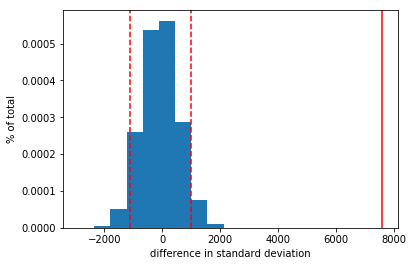

In [17]:
_ = plt.hist(bs_replicates, density=True)
_ = plt.xlabel('difference in standard deviation')
_ = plt.ylabel('% of total')
_ = plt.axvline(emp_diff, color='r')
_ = plt.axvline(np.percentile(bs_replicates,95), color='r', linestyle='--')
_ = plt.axvline(np.percentile(bs_replicates,5), color='r', linestyle='--')
plt.show()

This clearly shows that even for a very small significance level we would reject the null hypothesis.  

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type II error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this but using the bootstrap.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__  In this case, the null hypothesis will state that there is no difference between the means of insured and non-insured medical cases.  The alternative hypothesis will state that there is a difference between the means of insured and non-insured medical cases.  

In [18]:
charges_w_ins = med_charges[med_charges['insuranceclaim']==1]['charges']
charges_wo_ins = med_charges[med_charges['insuranceclaim']==0]['charges']

In [19]:
# Number of replicates we will be using
n_reps = 10000

# Compute the mean of all the charges
mean_charge = np.mean(np.concatenate((charges_w_ins,charges_wo_ins)))

# Generate shifted arrays
charges_w_shifted = charges_w_ins - np.mean(charges_w_ins) + mean_charge
charges_wo_shifted = charges_wo_ins - np.mean(charges_wo_ins) + mean_charge

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_w = draw_bs_reps(charges_w_shifted, np.mean, n_reps)
bs_replicates_wo = draw_bs_reps(charges_wo_shifted, np.mean, n_reps)

# Get replicates of difference of means:  bs_replicates
bs_replicates = bs_replicates_w - bs_replicates_wo

# Compute and print p-value:  p
p = np.sum(np.mean(charges_w_ins)-np.mean(charges_wo_ins) <= bs_replicates) / n_reps
print('p-value =', p)

p-value = 0.0


__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__

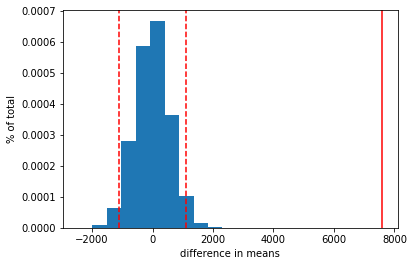

In [20]:
_ = plt.hist(bs_replicates, density=True)
_ = plt.xlabel('difference in means')
_ = plt.ylabel('% of total')
_ = plt.axvline(np.mean(charges_w_ins)-np.mean(charges_wo_ins), color='r')
_ = plt.axvline(np.percentile(bs_replicates,97.5), color='r', linestyle='--')
_ = plt.axvline(np.percentile(bs_replicates,2.5), color='r', linestyle='--')
plt.show()

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ In the previous assinment the p-value was 1.1105103216309125e-37.  It would take an unusually large number of replicates to get a p-value of that size.  

__Q:__ Remember the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ I would use the t-test where the variances were not equal.  

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real world consequence of rejecting the null hypothesis?

__A:__  In this case the null hypothesis would be that there is no difference in chick-through rate for the current algorithm and for the new algorithm.  The alternate hypothesis would be that there is a difference in click through rates for the current algorithm and for the new algorithm.  Rejecting the null hypothesis would suggest that the alternate hypothesis is true.  

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.